In [147]:
import numpy as np
import holotomo
import matplotlib.pyplot as plt
import tifffile
import cupy as cp
import holotomo
import glob
import dxchange
from ipywidgets import interact
import ipywidgets as widgets
import scipy.ndimage as ndimage
PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

cp.cuda.Device(0).use() # use first gpu

<CUDA Device 0>

In [148]:
n = 136 # data size after crop
fileprefix = '/data/NSLSII/3ID/projection_image/'
z1 = np.array([2.000,
2.086,
2.100,
2.190,
2.300,
2.399,
2.429,
2.500,
2.550,
2.607,
2.700,
2.793,
2.816,
3.000,
3.036,
3.129,
3.142,
3.200,
3.279,
3.299,
3.337,
3.500,
3.613,
3.644,
3.650,
3.886,
3.927,
4.000,
4.172,
4.241,
4.251,
4.712,
4.858,
5.027,
5.498,
6.283])*1e-3

z1=np.array([2,2.086,2.429, 3.142])*1e-3
z1=np.array([2.1,2.19009,2.55045,3.29868])*1e-3
z1=np.array([2.3,2.39867,2.79335,3.61284])*1e-3
z1=np.array([2.5,2.60725,3.03625,3.927])*1e-3
z1=np.array([2.7,2.81583,3.27915,4.24116])*1e-3
z1=np.array([3,3.1287,3.6435,4.7124])*1e-3
z1=np.array([3.2,3.33728,3.8864,5.02656])*1e-3
z1=np.array([3.5,3.65015,4.25075,5.4978])*1e-3
z1=np.array([4,4.1716,4.858,6.2832])*1e-3
# z1=np.array([3,3.1287,3.6435,4.7124])*1e-3

ndist = len(z1) # number of distanges
data0 = np.zeros([ndist,1,n,n],dtype='float32')
ref0 = np.zeros([1,n,n],dtype='float32')
dark0 = np.zeros([1,n,n],dtype='float32')
for k in range(ndist):
    id = int(z1[k]*1e6+0.5)
    print(f'{fileprefix}/S*{id}um*.tif')
    file = glob.glob(f'{fileprefix}/S*{id}um*.tif')
    # print(file)
    # print(len(file))
    # exit()
    for kk in range(5):
        data0[k] += tifffile.imread(file[kk])[785:785+136,278:278+136]
# for k in range(5):
#     file = glob.glob(f'{fileprefix}/S*2p0*{0+k}.tif')
#     data0[1] += tifffile.imread(file[0])[785:785+136,278:278+136]
# for k in range(5):
#     file = glob.glob(f'{fileprefix}/S*2p4*{0+k}.tif')
#     print(file)
#     data0[2] += tifffile.imread(file[0])[785:785+136,278:278+136]
# for k in range(5):
#     file = glob.glob(f'{fileprefix}/S*3p*{0+k}.tif')
#     data0[3] += tifffile.imread(file[0])[785:785+136,278:278+136]


for k in range(5):
    file = glob.glob(f'{fileprefix}/dar*{0+k}.tif')
    dark0 += tifffile.imread(file[0])[785:785+136,278:278+136]

for k in range(5):
    file = glob.glob(f'{fileprefix}/fl*{0+k}.tif')
    ref0 += tifffile.imread(file[0])[785:785+136,278:278+136]

rdata = (data0-dark0[:,np.newaxis])
rref = ref0-dark0
rref[rref<0] = 0
rdata[rdata<0]=0
rdata/=(rref[:,np.newaxis]+1e-9)


def plot_rec(sid=1):
    plt.figure(figsize=(8,6))
    plt.imshow(rdata[sid,0],cmap='gray',vmax=2)    
    plt.colorbar()
interact(plot_rec, sid = widgets.IntSlider(value=0,
                                               min=0,
                                               max=rdata.shape[0]-1,
                                               step=1))    

/data/NSLSII/3ID/projection_image//S*4000um*.tif
/data/NSLSII/3ID/projection_image//S*4172um*.tif
/data/NSLSII/3ID/projection_image//S*4858um*.tif
/data/NSLSII/3ID/projection_image//S*6283um*.tif


interactive(children=(IntSlider(value=0, description='sid', max=3), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_rec(sid=1)>

# Init data sizes and parametes of the HXN of 3ID

In [149]:
energy = 14  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.06 # [m]
pixelsize=75e-6
voxelsize=pixelsize/(focusToDetectorDistance/z1[0])
print(f'{voxelsize=}')
# z1 = np.array([2e-3])[:ndist] # positions of the sample (1 position is enough when using several codes)
z2 = focusToDetectorDistance-z1 # propagation distance between the code and detector
magnifications = (z1+z2)/z1 # magnification when propagating from the sample to the code
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes
z1p = z1[0]  # positions of the probe for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # 
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2


voxelsize=2.830188679245283e-07


In [150]:
rdata_scaled = rdata.copy()
for j in range(1):
    for k in range(ndist):    
        a = ndimage.zoom(rdata[k,j],1/norm_magnifications[k])
        rdata_scaled[k,j] = a[a.shape[0]//2-n//2:a.shape[0]//2+n//2,a.shape[1]//2-n//2:a.shape[1]//2+n//2]

def plot_rec(sid=1):
    plt.figure(figsize=(8,6))
    plt.imshow(rdata_scaled[sid,0],cmap='gray',vmax=2)    
    plt.colorbar()
interact(plot_rec, sid = widgets.IntSlider(value=0,
                                               min=0,
                                               max=rdata.shape[0]-1,
                                               step=1))    

interactive(children=(IntSlider(value=0, description='sid', max=3), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_rec(sid=1)>

# find shifts accurately

In [151]:
def apply_shift(psi, p):
    """Apply shift for all projections."""
    psi = cp.array(psi)
    p = cp.array(p)
    tmp = cp.pad(psi,((0,0),(n//2,n//2),(n//2,n//2)), 'symmetric')
    [x, y] = cp.meshgrid(cp.fft.rfftfreq(2*n),
                         cp.fft.fftfreq(2*n))
    shift = cp.exp(-2*cp.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    print(shift.shape,tmp.shape)
    res0 = cp.fft.irfft2(shift*cp.fft.rfft2(tmp))
    res = res0[:, n//2:3*n//2, n//2:3*n//2].get()
    return res

def _upsampled_dft(data, ups,
                   upsample_factor=1, axis_offsets=None):

    im2pi = 1j * 2 * np.pi
    tdata = data.copy()
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 1:2])[
        :, :, None]*np.fft.fftfreq(data.shape[2], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    tdata = np.einsum('ijk,ipk->ijp', kernel, tdata)
    kernel = (np.tile(np.arange(ups), (data.shape[0], 1))-axis_offsets[:, 0:1])[
        :, :, None]*np.fft.fftfreq(data.shape[1], upsample_factor)
    kernel = np.exp(-im2pi * kernel)
    rec = np.einsum('ijk,ipk->ijp', kernel, tdata)

    return rec

def registration_shift(src_image, target_image, upsample_factor=1, space="real"):

    # assume complex data is already in Fourier space
    if space.lower() == 'fourier':
        src_freq = src_image
        target_freq = target_image
    # real data needs to be fft'd.
    elif space.lower() == 'real':
        src_freq = np.fft.fft2(src_image)
        target_freq = np.fft.fft2(target_image)

    # Whole-pixel shift - Compute cross-correlation by an IFFT
    shape = src_freq.shape
    image_product = src_freq * target_freq.conj()
    cross_correlation = np.fft.ifft2(image_product)
    A = np.abs(cross_correlation)
    maxima = A.reshape(A.shape[0], -1).argmax(1)
    maxima = np.column_stack(np.unravel_index(maxima, A[0, :, :].shape))

    midpoints = np.array([np.fix(axis_size / 2)
                          for axis_size in shape[1:]])

    shifts = np.array(maxima, dtype=np.float64)
    ids = np.where(shifts[:, 0] > midpoints[0])
    shifts[ids[0], 0] -= shape[1]
    ids = np.where(shifts[:, 1] > midpoints[1])
    shifts[ids[0], 1] -= shape[2]
    
    if upsample_factor > 1:
        # Initial shift estimate in upsampled grid
        shifts = np.round(shifts * upsample_factor) / upsample_factor
        upsampled_region_size = np.ceil(upsample_factor * 1.5)
        # Center of output array at dftshift + 1
        dftshift = np.fix(upsampled_region_size / 2.0)

        normalization = (src_freq[0].size * upsample_factor ** 2)
        # Matrix multiply DFT around the current shift estimate

        sample_region_offset = dftshift - shifts*upsample_factor
        cross_correlation = _upsampled_dft(image_product.conj(),
                                                upsampled_region_size,
                                                upsample_factor,
                                                sample_region_offset).conj()
        cross_correlation /= normalization
        # Locate maximum and map back to original pixel grid
        A = np.abs(cross_correlation)
        maxima = A.reshape(A.shape[0], -1).argmax(1)
        maxima = np.column_stack(
            np.unravel_index(maxima, A[0, :, :].shape))

        maxima = np.array(maxima, dtype=np.float64) - dftshift

        shifts = shifts + maxima / upsample_factor
           
    return shifts

shifts_dist = np.zeros([ndist,1,2],dtype='float32')
rdata_scaled_shifted=rdata_scaled.copy()
for j in range(1):
    for k in range(0,ndist):#!!!!!!!!!!!!!!
        shifts_dist[k,j] = registration_shift(rdata_scaled[k,j:j+1],rdata_scaled[0,j:j+1],upsample_factor=10)
        rdata_scaled_shifted[k,j:j+1] = apply_shift(rdata_scaled[k,j:j+1],-shifts_dist[k,j:j+1])# note first shift then magnification    
        
        print(f'{k} {j}: {shifts_dist[k,j]}')
# raise Exception

(1, 272, 137) (1, 272, 272)
0 0: [0. 0.]
(1, 272, 137) (1, 272, 272)
1 0: [ 0.1 -0.5]
(1, 272, 137) (1, 272, 272)
2 0: [ 1.6 -1.9]
(1, 272, 137) (1, 272, 272)
3 0: [-38.   15.9]


In [152]:
def plot_rec(sid=1):
    plt.figure(figsize=(8,6))
    plt.imshow(rdata_scaled_shifted[sid,0],cmap='gray',vmax=2)    
    plt.colorbar()
interact(plot_rec, sid = widgets.IntSlider(value=0,
                                               min=0,
                                               max=rdata_scaled_shifted.shape[0]-1,
                                               step=1))    

interactive(children=(IntSlider(value=0, description='sid', max=3), Output()), _dom_classes=('widget-interact'…

<function __main__.plot_rec(sid=1)>

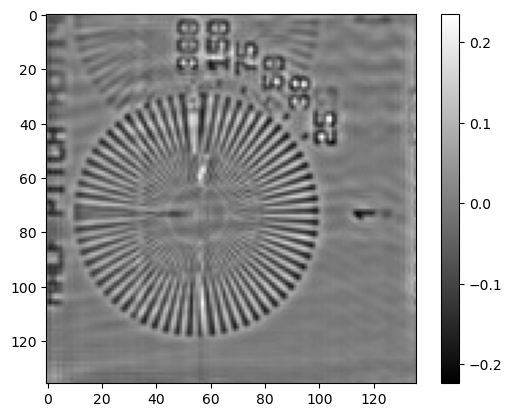

In [153]:
def CTFPurePhase(rads, wlen, dists, fx, fy, alpha):
   """
   weak phase approximation from Cloetens et al. 2002




   Parameters
   ----------
   rad : 2D-array
       projection.
   wlen : float
       X-ray wavelentgth assumes monochromatic source.
   dist : float
       Object to detector distance (propagation distance) in mm.
   fx, fy : ndarray
       Fourier conjugate / spatial frequency coordinates of x and y.
   alpha : float
       regularization factor.
       
   Return
   ------
   phase retrieved projection in real space
   """    
   numerator = 0
   denominator = 0    
   for j in range(0, len(dists)):    
       rad_freq = np.fft.fft2(rads[j])
       taylorExp = np.sin(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
       numerator = numerator + taylorExp * (rad_freq)
       denominator = denominator + 2*taylorExp**2 
   numerator = numerator / len(dists)
   denominator = (denominator / len(dists)) + alpha
   phase = np.real(  np.fft.ifft2(numerator / denominator) )
   phase = 0.5 * phase
   return phase


distances_rec = (distances/norm_magnifications**2)[:ndist]

fx = np.fft.fftfreq(n,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)

wlen = 1.24e-9/energy
recCTFPurePhase = np.zeros([1,n,n],dtype='complex64')
for k in range(1):
    rads = rdata_scaled_shifted[:ndist,k]
    recCTFPurePhase[k] = np.exp(1j*CTFPurePhase(rads, wlen, distances_rec, fx, fy, 1e-1))
plt.imshow(np.angle(recCTFPurePhase[-1]),cmap='gray')
plt.colorbar()
# dxchange.write_tiff(np.angle(recCTFPurePhase),f'/data/vnikitin/holo/r{n}_{ntheta}_{ndist}/CTF.tiff',overwrite=True)



# Create solver class

In [154]:
pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications,distances2,same_probe=True)

shifting flat


# Adjoint test for holography with double propagation

In [155]:
shifts = shifts_dist
data = data0.copy()
ref = np.tile(ref0,[ndist,1,1])#.copy()
arr1 = np.pad(np.array(data[0]+1j*data[0]).astype('complex64'),((0,0),(n//2,n//2),(n//2,n//2)),'symmetric')
prb1 = np.array(ref[:]+1j*ref[:]).astype('complex64')
shifts_ref = shifts[:]
print(arr1.shape,prb1.shape,shifts_ref.shape)
print(distances, distances2)
arr2 = pslv.fwd_holo_batch(arr1,prb1, shifts_ref)
arr3 = pslv.adj_holo_batch(arr2,prb1, shifts_ref)
prb3 = pslv.adj_holo_prb_batch(arr2,arr1, shifts_ref)



print(np.sum(arr1*np.conj(arr3)))
print(np.sum(arr2*np.conj(arr2)))
print(np.sum(prb1*np.conj(prb3)))

(1, 272, 272) (4, 136, 136) (4, 1, 2)
[0.00398491 0.00382036 0.00327844 0.00253138] [0.         0.00016454 0.00070646 0.00145353]
(2.8212402e+25-1.2001741e+18j)
(2.8212402e+25+1645801700000000j)
(2.82124e+25-4.2263468e+17j)


## Gradient descent with the line search

In [156]:
flg_show = True
same_probe = True
ntheta = 1
def line_search(minf, gamma, fu, fu0, fd, fd0):
    """ Line search for the step sizes gamma"""
    while(minf(fu,fu0)-minf(fu+gamma*fd, fu0+gamma*fd0) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
def cg_holo(pslv, pslv0, data, data_ref, init, init_prb,  piter,shifts, upd_psi=True, upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Conjugate gradients method for holography"""

    data = cp.sqrt(data)
    data_ref = cp.sqrt(data_ref)

    # minimization functional
    def minf(fpsi,fprb):
        f = cp.linalg.norm(cp.abs(fpsi)-data)**2            
        f += cp.linalg.norm(cp.abs(fprb)-data_ref)**2        
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    gammapsi = gammapsi0
    gammaprb = gammaprb0
    shifts = cp.array(shifts)
    psi_nil = psi*0+1
    shifts_nil = shifts*0+1
    
    for i in range(piter):
        if upd_psi:
            
            fpsi = pslv.fwd_holo(psi,prb,shifts)          
            d = -pslv.adj_holo(fpsi-data*cp.exp(1j*(cp.angle(fpsi))), prb,shifts)/cp.max(cp.abs(prb))**2#/ndist**2

            fd = pslv.fwd_holo(d, prb,shifts)     
            gammapsi = line_search(minf, gammapsi0, fpsi, 0, fd, 0)
            psi = psi+gammapsi*d
            
        if upd_prb:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts*0)
            dprb = pslv.adj_holo_prb(fprb-data*cp.exp(1j*cp.angle(fprb)),psi,shifts)
            dprb += pslv0.adj_holo_prb(fprb0-data_ref*cp.exp(1j*cp.angle(fprb0)),psi_nil,shifts_nil)
            dprb*=-1/((pslv.ntheta+1))

            # line search
            fdprb = pslv.fwd_holo(psi, dprb,shifts)
            fdprb0 = pslv0.fwd_holo(psi_nil, dprb,shifts*0)
            
            gammaprb = line_search(minf,gammaprb0, fprb, fprb0, fdprb, fdprb0)
            prb = prb + gammaprb*dprb
            
        if i%step==0:
            fprb = pslv.fwd_holo(psi,prb,shifts)
            fprb0 = pslv0.fwd_holo(psi_nil,prb,shifts*0)            
            err=minf(fprb,fprb0)
            print(f'{i}) {gammapsi=} {gammaprb=}, {err=:1.5e}')  

        
        if i%vis_step==0:  
            if flg_show:
                fig, axs = plt.subplots(1, 2, figsize=(10, 5))
                im=axs[0].imshow(np.angle(recCTFPurePhase[0]),cmap='gray')
                axs[0].set_title('reconstructed CTF phase')
                fig.colorbar(im)
                im=axs[1].imshow(cp.angle(psi[0,n//2:-n//2,n//2:-n//2]).get(),cmap='gray')
                axs[1].set_title('reconstructed phase')
                fig.colorbar(im)                
                plt.show()
            # dxchange.write_tiff(cp.angle(psi).get(),f'/data/vnikitin/holo/NSLS2/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{z1[0]*1000}um/r{i:05}.tiff',overwrite=True)
            dxchange.write_tiff(cp.angle(psi[0]).get(),f'/data/vnikitin/holo/NSLS2/rsame_probe_{same_probe}_{n}_{ntheta}_{ndist}_{z1[0]*1000}um/o{i:05}.tiff',overwrite=True)
                        
            
    return psi,prb

def cg_holo_batch(pslv, pslv0, data,data_ref, init, prb_init, piter,shifts=None,upd_psi=True,upd_prb=False,step=1,vis_step=1,gammapsi0=1,gammaprb0=1):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, 2*pslv.n, 2*pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                

    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        data_ref_gpu = cp.array(data_ref)
        
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, pslv0, data_gpu,data_ref_gpu, init_gpu,prb_init_gpu, piter,shifts,upd_psi, upd_prb,step,vis_step,gammapsi0,gammaprb0)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb


shifting flat
shifting flat


0) gammapsi=1 gammaprb=1, err=2.74371e-02


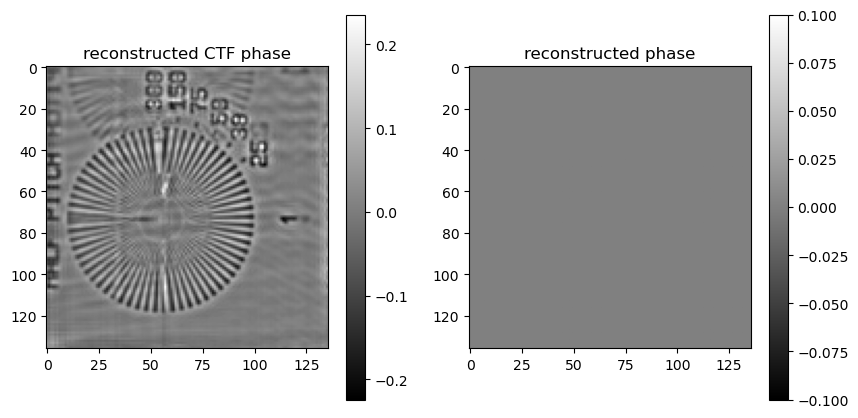

1) gammapsi=1 gammaprb=1, err=1.37530e-02
2) gammapsi=1 gammaprb=1, err=1.36686e-02
3) gammapsi=1 gammaprb=1, err=1.37955e-02
4) gammapsi=1 gammaprb=1, err=1.37756e-02
5) gammapsi=1 gammaprb=1, err=1.38305e-02
6) gammapsi=1 gammaprb=1, err=1.38722e-02
7) gammapsi=1 gammaprb=1, err=1.38321e-02
8) gammapsi=1 gammaprb=1, err=1.38105e-02
9) gammapsi=1 gammaprb=1, err=1.37146e-02
10) gammapsi=1 gammaprb=1, err=1.38478e-02
11) gammapsi=1 gammaprb=1, err=1.38087e-02
12) gammapsi=1 gammaprb=1, err=1.37091e-02
13) gammapsi=1 gammaprb=1, err=1.37027e-02
14) gammapsi=1 gammaprb=1, err=1.37355e-02
15) gammapsi=1 gammaprb=1, err=1.37059e-02
16) gammapsi=1 gammaprb=1, err=1.39195e-02
17) gammapsi=1 gammaprb=1, err=1.37251e-02
18) gammapsi=1 gammaprb=1, err=1.37169e-02
19) gammapsi=1 gammaprb=1, err=1.37908e-02
20) gammapsi=1 gammaprb=1, err=1.37689e-02
21) gammapsi=1 gammaprb=1, err=1.38677e-02
22) gammapsi=1 gammaprb=1, err=1.37440e-02
23) gammapsi=1 gammaprb=1, err=1.40058e-02
24) gammapsi=1 gamma

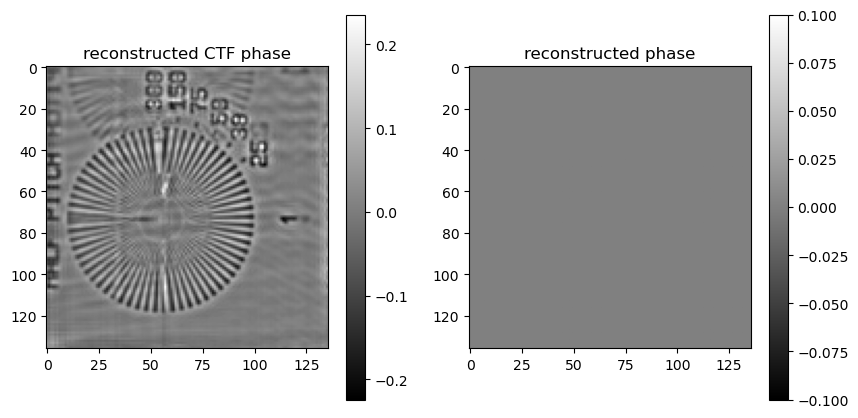

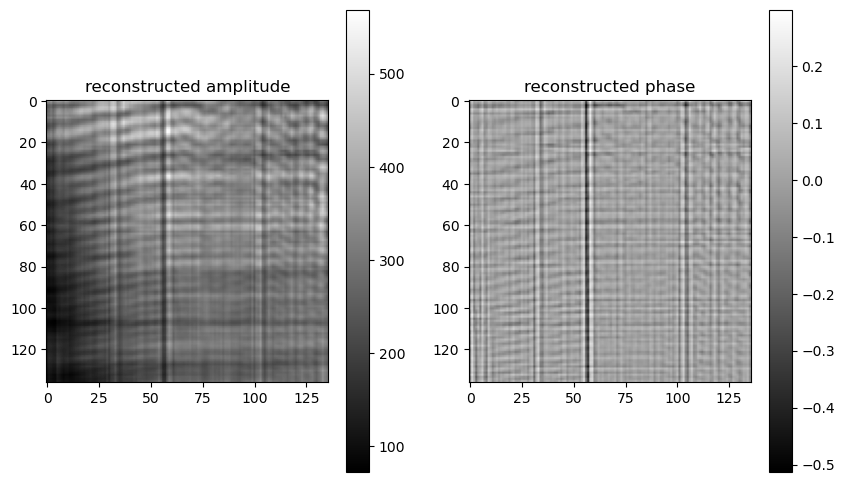

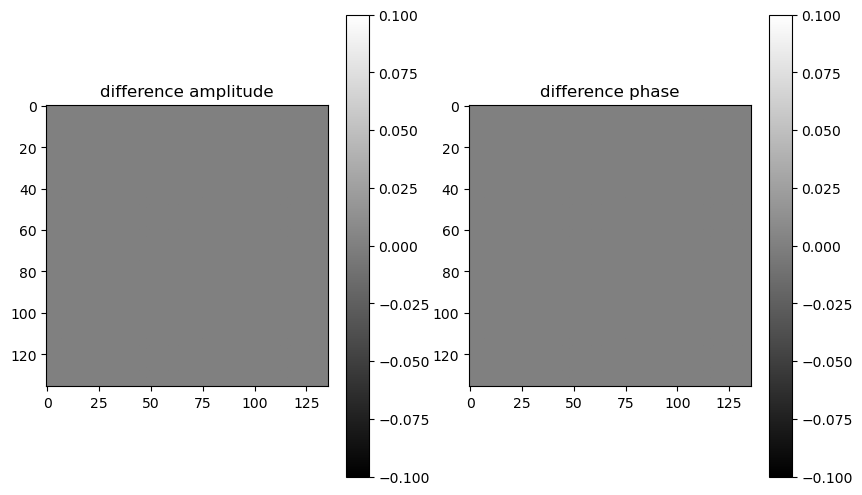

In [157]:

pslv = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 
pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances, norm_magnifications, distances2,same_probe=same_probe) 


rec = np.ones([1,2*n,2*n],dtype='complex64')
rec_prb = np.ones([ndist,n,n],dtype='complex64')        
data_ref = rref[:,np.newaxis]
shifts_ref = np.array(shifts)[:,:1]*0
_,rec_prb0 = cg_holo_batch(pslv0, pslv0, data_ref, data_ref, rec, rec_prb, 32, shifts_ref, False,True,1,31,1,1)
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    im=axs[0].imshow(np.abs(rec_prb0[0]),cmap='gray')
    axs[0].set_title('reconstructed amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(rec_prb0[0]),cmap='gray')
    axs[1].set_title('reconstructed phase')
    fig.colorbar(im)
if flg_show:
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))
    im=axs[0].imshow(np.abs(rec_prb0[0])-np.abs(rec_prb0[-1]),cmap='gray')
    axs[0].set_title('difference amplitude')
    fig.colorbar(im)
    im=axs[1].imshow(np.angle(rec_prb0[0])-np.angle(rec_prb0[-1]),cmap='gray')
    axs[1].set_title('difference phase')
    fig.colorbar(im)


## $\ \sum_j\sum_i||\mathcal{G}_{d_j}((\mathcal{G}_{d'_j}q)(M_j S_{r_{ij}}\psi))|-\sqrt{\text{I}_{ij}}\|^2_2\to \text{min}_{\psi,q}$ 

0) gammapsi=0.5 gammaprb=1, err=5.16182e+07


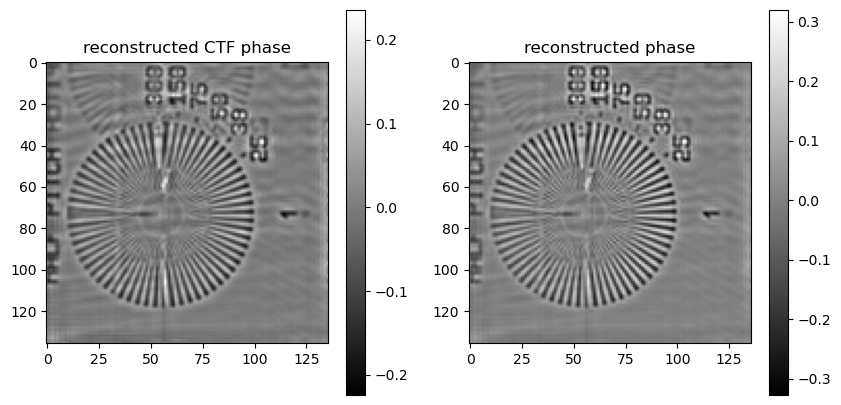

32) gammapsi=0.5 gammaprb=1, err=1.34874e+07


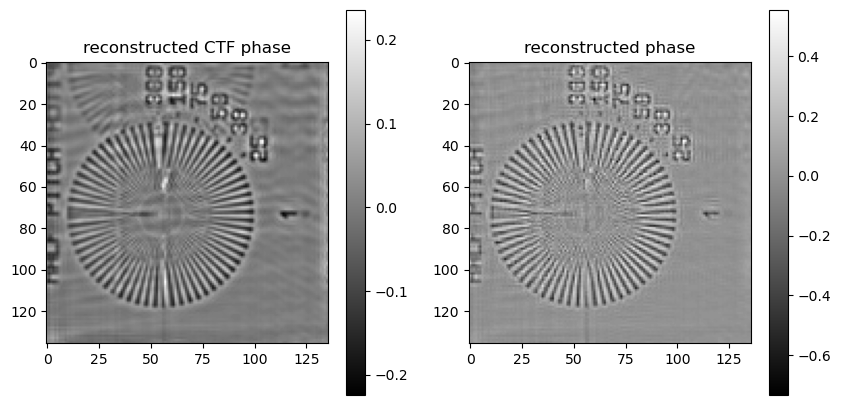

64) gammapsi=0.5 gammaprb=1, err=9.69405e+06


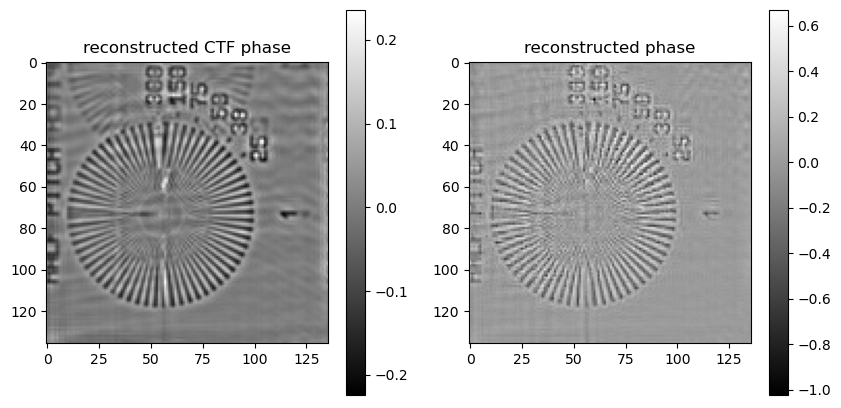

96) gammapsi=0.5 gammaprb=1, err=7.34537e+06


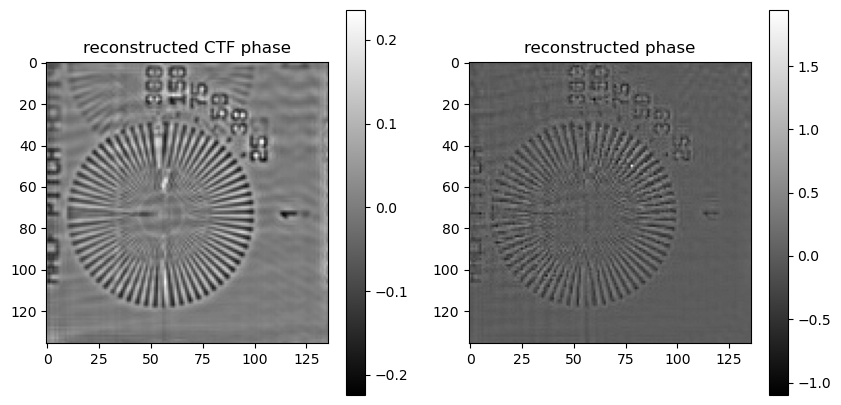

128) gammapsi=0.5 gammaprb=1, err=5.68083e+06


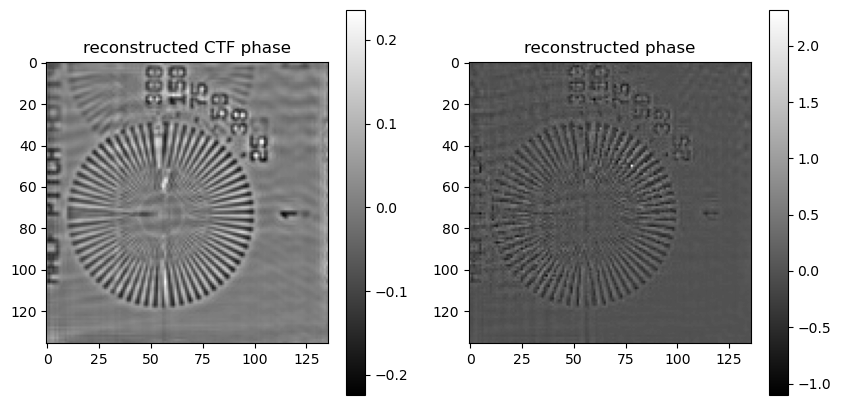

: 

In [158]:
shifts_rec = np.array(shifts)
rec = np.ones([ntheta,2*n,2*n],dtype='complex64')
rec = np.pad(recCTFPurePhase,((0,0),(n//2,n//2),(n//2,n//2)),'edge')
# use only the abs value of the probe as initial guess
rec_prb[:] = rec_prb0
niter = 129
iter_step = 32
rec,rec_prb = cg_holo_batch(pslv, pslv0, data, data_ref, rec, rec_prb, niter, shifts_rec, True,True,iter_step,iter_step, 0.5,1)